# Exercise 4

## Import packages

In [117]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [118]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for index, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        prediction = model(images)
        loss = F.nll_loss(prediction, labels)
        loss.backward()
        optimizer.step()
        if index % log_interval == 0:
            print(f"epoch: {epoch}, index: {index}, loss: {loss.item():.4f}")
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [119]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [120]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.s1 = nn.Sigmoid()
        self.fc2 = nn.Linear(200, 100)
        self.s2 = nn.Sigmoid()
        self.fc3 = nn.Linear(100, 60)
        self.s3 = nn.Sigmoid()
        self.fc4 = nn.Linear(60, 30)
        self.s4 = nn.Sigmoid()
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(start_dim=1)
        
        # TODO: run network layers
        x = self.fc1(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        x = self.fc4(x)
        x = self.s4(x)
        x = self.fc5(x)




        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        return output

In [121]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.s1 = nn.ReLU()
        self.fc2 = nn.Linear(200, 100)
        self.s2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 60)
        self.s3 = nn.ReLU()
        self.fc4 = nn.Linear(60, 30)
        self.s4 = nn.ReLU()
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        x = self.fc4(x)
        x = self.s4(x)
        x = self.fc5(x)

        output = F.log_softmax(x, dim=1)
        return output

In [122]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.s1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100)
        self.s2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 60)
        self.s3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60, 30)
        self.s4 = nn.ReLU()
        self.fc5 = nn.Linear(30, 10)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.s3(x)
        x = self.fc4(x)
        x = self.s4(x)
        x = self.fc5(x)

        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [123]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.cv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.s1 = nn.ReLU()

    def forward(self, x):
        x = self.cv1(x)
        x = self.cv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.s1(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        
        return output

In [124]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.cv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.s1 = nn.ReLU()

    def forward(self, x):
        x = self.cv1(x)
        x = self.bn1(x)
        x = self.cv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.s1(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

In [125]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.cv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.s1 = nn.ReLU()

    def forward(self, x):
        x = self.cv1(x)
        x = self.bn1(x)
        x = self.cv2(x)
        x = self.mp2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.s1(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

epoch: 1, index: 0, loss: 2.3637
epoch: 1, index: 100, loss: 2.3113
epoch: 1, index: 200, loss: 2.3063
epoch: 1, index: 300, loss: 2.3078
epoch: 1, index: 400, loss: 2.3142
epoch: 1, index: 500, loss: 2.3232
epoch: 1, index: 600, loss: 2.3058
epoch: 1, index: 700, loss: 2.2533
epoch: 1, index: 800, loss: 1.7327
epoch: 1, index: 900, loss: 1.4127

Test set: Average loss: 1.2453, Accuracy: 5276/10000 (52.76%)



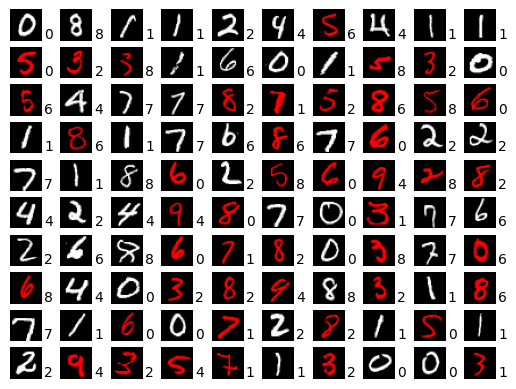

epoch: 2, index: 0, loss: 1.2802
epoch: 2, index: 100, loss: 1.1899
epoch: 2, index: 200, loss: 0.9635
epoch: 2, index: 300, loss: 0.7349
epoch: 2, index: 400, loss: 0.7296
epoch: 2, index: 500, loss: 0.6201
epoch: 2, index: 600, loss: 0.5258
epoch: 2, index: 700, loss: 0.4492
epoch: 2, index: 800, loss: 0.5399
epoch: 2, index: 900, loss: 0.2650

Test set: Average loss: 0.4452, Accuracy: 8971/10000 (89.71%)



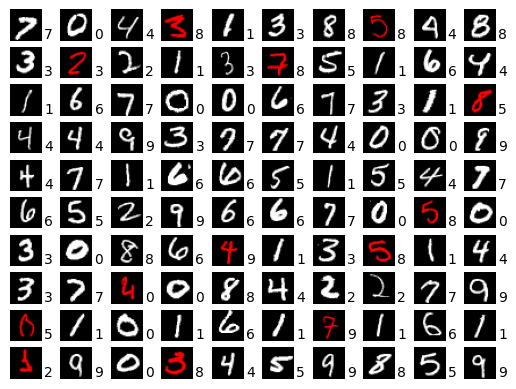

epoch: 3, index: 0, loss: 0.3494
epoch: 3, index: 100, loss: 0.3201
epoch: 3, index: 200, loss: 0.4225
epoch: 3, index: 300, loss: 0.1710
epoch: 3, index: 400, loss: 0.2991
epoch: 3, index: 500, loss: 0.4662
epoch: 3, index: 600, loss: 0.1753
epoch: 3, index: 700, loss: 0.4117
epoch: 3, index: 800, loss: 0.2622
epoch: 3, index: 900, loss: 0.4048

Test set: Average loss: 0.3548, Accuracy: 9106/10000 (91.06%)



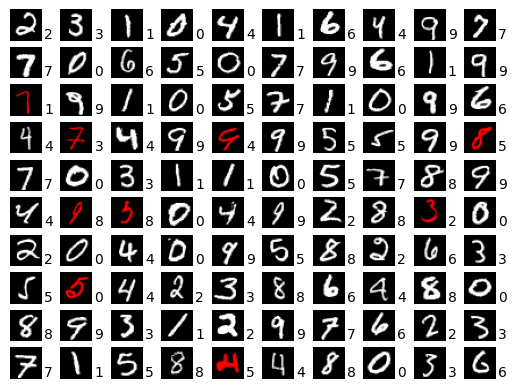

epoch: 4, index: 0, loss: 0.4082
epoch: 4, index: 100, loss: 0.1954
epoch: 4, index: 200, loss: 0.1009
epoch: 4, index: 300, loss: 0.4593
epoch: 4, index: 400, loss: 0.2151
epoch: 4, index: 500, loss: 0.2771
epoch: 4, index: 600, loss: 0.2361
epoch: 4, index: 700, loss: 0.1906
epoch: 4, index: 800, loss: 0.2856
epoch: 4, index: 900, loss: 0.2645

Test set: Average loss: 0.2813, Accuracy: 9293/10000 (92.93%)



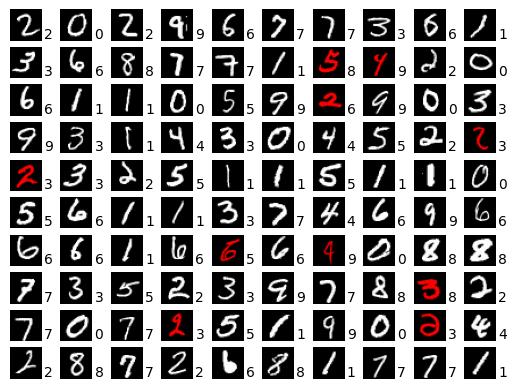

epoch: 5, index: 0, loss: 0.1974
epoch: 5, index: 100, loss: 0.2291
epoch: 5, index: 200, loss: 0.2431
epoch: 5, index: 300, loss: 0.1869
epoch: 5, index: 400, loss: 0.1697
epoch: 5, index: 500, loss: 0.2004
epoch: 5, index: 600, loss: 0.1273
epoch: 5, index: 700, loss: 0.1012
epoch: 5, index: 800, loss: 0.2195
epoch: 5, index: 900, loss: 0.2061

Test set: Average loss: 0.2277, Accuracy: 9444/10000 (94.44%)



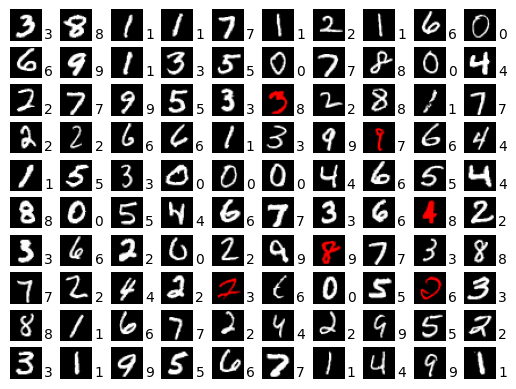

epoch: 6, index: 0, loss: 0.0696
epoch: 6, index: 100, loss: 0.1517
epoch: 6, index: 200, loss: 0.2833
epoch: 6, index: 300, loss: 0.1635
epoch: 6, index: 400, loss: 0.1727
epoch: 6, index: 500, loss: 0.3618
epoch: 6, index: 600, loss: 0.0551
epoch: 6, index: 700, loss: 0.2071
epoch: 6, index: 800, loss: 0.1115
epoch: 6, index: 900, loss: 0.1648

Test set: Average loss: 0.2342, Accuracy: 9425/10000 (94.25%)



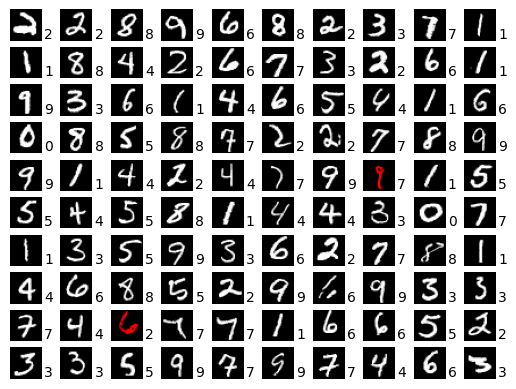

epoch: 7, index: 0, loss: 0.2671
epoch: 7, index: 100, loss: 0.1837
epoch: 7, index: 200, loss: 0.2480
epoch: 7, index: 300, loss: 0.1413
epoch: 7, index: 400, loss: 0.2445
epoch: 7, index: 500, loss: 0.0620
epoch: 7, index: 600, loss: 0.1399
epoch: 7, index: 700, loss: 0.2638
epoch: 7, index: 800, loss: 0.0706
epoch: 7, index: 900, loss: 0.3073

Test set: Average loss: 0.2043, Accuracy: 9514/10000 (95.14%)



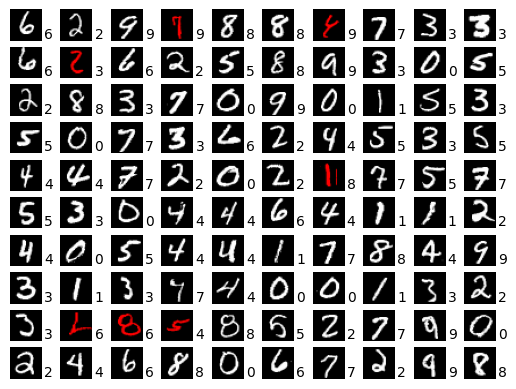

epoch: 8, index: 0, loss: 0.1162
epoch: 8, index: 100, loss: 0.2240
epoch: 8, index: 200, loss: 0.0716
epoch: 8, index: 300, loss: 0.0866
epoch: 8, index: 400, loss: 0.1107
epoch: 8, index: 500, loss: 0.1238
epoch: 8, index: 600, loss: 0.1596
epoch: 8, index: 700, loss: 0.1423
epoch: 8, index: 800, loss: 0.0450
epoch: 8, index: 900, loss: 0.1912

Test set: Average loss: 0.2002, Accuracy: 9509/10000 (95.09%)



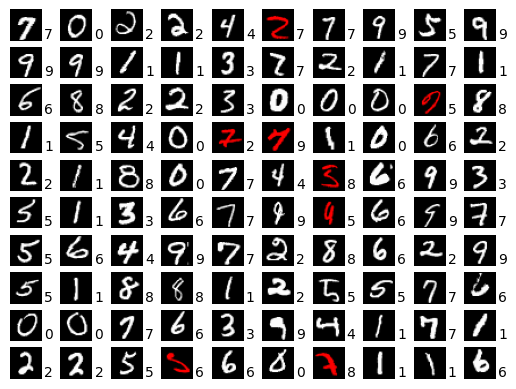

epoch: 9, index: 0, loss: 0.0692
epoch: 9, index: 100, loss: 0.1135
epoch: 9, index: 200, loss: 0.0763
epoch: 9, index: 300, loss: 0.2028
epoch: 9, index: 400, loss: 0.0552
epoch: 9, index: 500, loss: 0.1470
epoch: 9, index: 600, loss: 0.0551
epoch: 9, index: 700, loss: 0.0329
epoch: 9, index: 800, loss: 0.1126
epoch: 9, index: 900, loss: 0.2889

Test set: Average loss: 0.1965, Accuracy: 9521/10000 (95.21%)



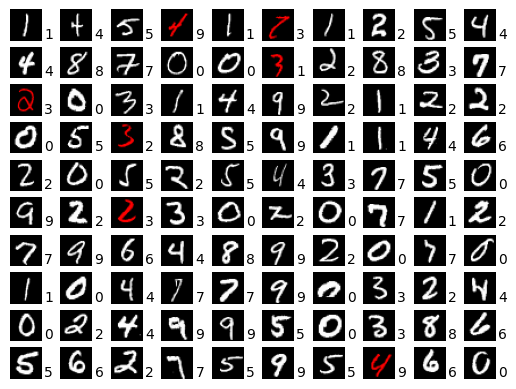

epoch: 10, index: 0, loss: 0.0797
epoch: 10, index: 100, loss: 0.0420
epoch: 10, index: 200, loss: 0.1371
epoch: 10, index: 300, loss: 0.0787
epoch: 10, index: 400, loss: 0.0768
epoch: 10, index: 500, loss: 0.0501
epoch: 10, index: 600, loss: 0.1488
epoch: 10, index: 700, loss: 0.1731
epoch: 10, index: 800, loss: 0.1876
epoch: 10, index: 900, loss: 0.0498

Test set: Average loss: 0.1947, Accuracy: 9527/10000 (95.27%)



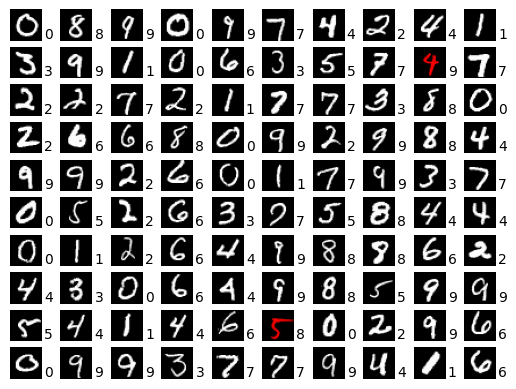

epoch: 1, index: 0, loss: 2.3159
epoch: 1, index: 100, loss: 0.6038
epoch: 1, index: 200, loss: 0.3050
epoch: 1, index: 300, loss: 0.3949
epoch: 1, index: 400, loss: 0.3910
epoch: 1, index: 500, loss: 0.2554
epoch: 1, index: 600, loss: 0.0594
epoch: 1, index: 700, loss: 0.1967
epoch: 1, index: 800, loss: 0.1926
epoch: 1, index: 900, loss: 0.1829

Test set: Average loss: 0.1342, Accuracy: 9598/10000 (95.98%)



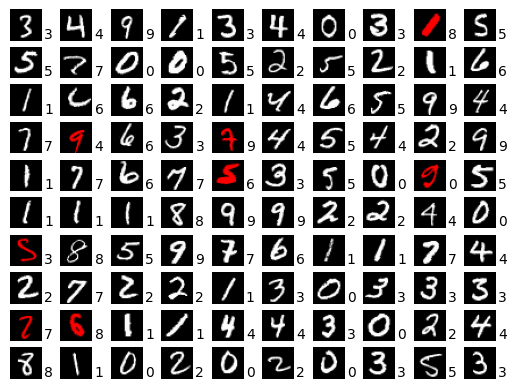

epoch: 2, index: 0, loss: 0.0482
epoch: 2, index: 100, loss: 0.0913
epoch: 2, index: 200, loss: 0.0157
epoch: 2, index: 300, loss: 0.1242
epoch: 2, index: 400, loss: 0.1564
epoch: 2, index: 500, loss: 0.0834
epoch: 2, index: 600, loss: 0.0623
epoch: 2, index: 700, loss: 0.0298
epoch: 2, index: 800, loss: 0.1199
epoch: 2, index: 900, loss: 0.0337

Test set: Average loss: 0.0951, Accuracy: 9704/10000 (97.04%)



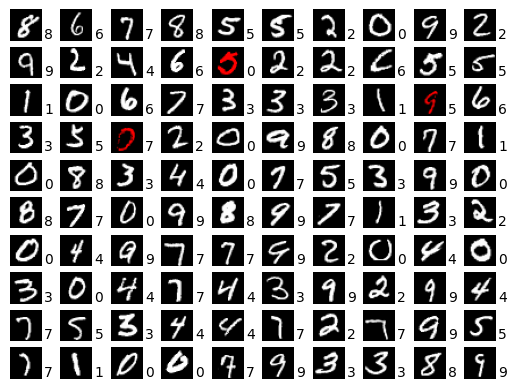

epoch: 3, index: 0, loss: 0.0499
epoch: 3, index: 100, loss: 0.0451
epoch: 3, index: 200, loss: 0.0913
epoch: 3, index: 300, loss: 0.0320
epoch: 3, index: 400, loss: 0.1446
epoch: 3, index: 500, loss: 0.0098
epoch: 3, index: 600, loss: 0.0275
epoch: 3, index: 700, loss: 0.1246
epoch: 3, index: 800, loss: 0.0253
epoch: 3, index: 900, loss: 0.0455

Test set: Average loss: 0.0846, Accuracy: 9777/10000 (97.77%)



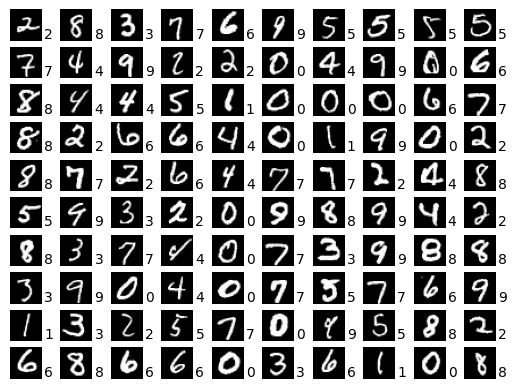

epoch: 4, index: 0, loss: 0.0073
epoch: 4, index: 100, loss: 0.0671
epoch: 4, index: 200, loss: 0.0103
epoch: 4, index: 300, loss: 0.0475
epoch: 4, index: 400, loss: 0.0305
epoch: 4, index: 500, loss: 0.0060
epoch: 4, index: 600, loss: 0.0013
epoch: 4, index: 700, loss: 0.1570
epoch: 4, index: 800, loss: 0.0112
epoch: 4, index: 900, loss: 0.0396

Test set: Average loss: 0.0735, Accuracy: 9811/10000 (98.11%)



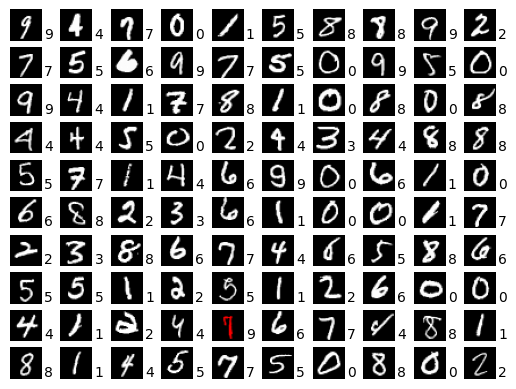

epoch: 5, index: 0, loss: 0.0056
epoch: 5, index: 100, loss: 0.0001
epoch: 5, index: 200, loss: 0.0034
epoch: 5, index: 300, loss: 0.0099
epoch: 5, index: 400, loss: 0.0009
epoch: 5, index: 500, loss: 0.0037
epoch: 5, index: 600, loss: 0.0147
epoch: 5, index: 700, loss: 0.0141
epoch: 5, index: 800, loss: 0.1202
epoch: 5, index: 900, loss: 0.0052

Test set: Average loss: 0.0751, Accuracy: 9823/10000 (98.23%)



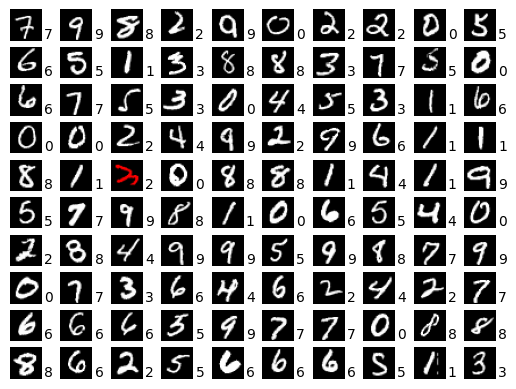

epoch: 6, index: 0, loss: 0.0014
epoch: 6, index: 100, loss: 0.0041
epoch: 6, index: 200, loss: 0.0056
epoch: 6, index: 300, loss: 0.0015
epoch: 6, index: 400, loss: 0.0061
epoch: 6, index: 500, loss: 0.0566
epoch: 6, index: 600, loss: 0.0001
epoch: 6, index: 700, loss: 0.0006
epoch: 6, index: 800, loss: 0.0178
epoch: 6, index: 900, loss: 0.0028

Test set: Average loss: 0.0805, Accuracy: 9818/10000 (98.18%)



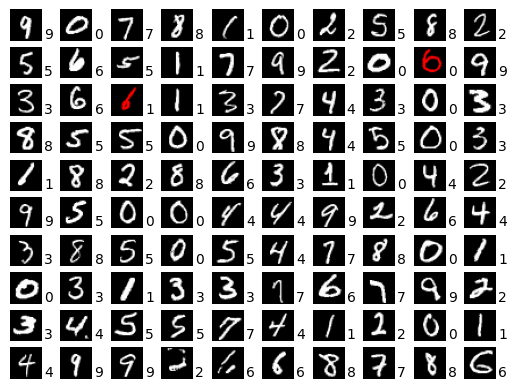

epoch: 7, index: 0, loss: 0.0686
epoch: 7, index: 100, loss: 0.0012
epoch: 7, index: 200, loss: 0.1293
epoch: 7, index: 300, loss: 0.0126
epoch: 7, index: 400, loss: 0.0065
epoch: 7, index: 500, loss: 0.0002
epoch: 7, index: 600, loss: 0.0004
epoch: 7, index: 700, loss: 0.0004
epoch: 7, index: 800, loss: 0.0929
epoch: 7, index: 900, loss: 0.0003

Test set: Average loss: 0.0801, Accuracy: 9824/10000 (98.24%)



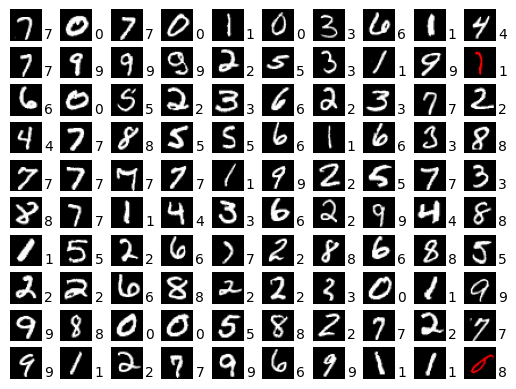

epoch: 8, index: 0, loss: 0.0006
epoch: 8, index: 100, loss: 0.0758
epoch: 8, index: 200, loss: 0.0048
epoch: 8, index: 300, loss: 0.0907
epoch: 8, index: 400, loss: 0.0033
epoch: 8, index: 500, loss: 0.0016
epoch: 8, index: 600, loss: 0.0091
epoch: 8, index: 700, loss: 0.0014
epoch: 8, index: 800, loss: 0.0015
epoch: 8, index: 900, loss: 0.0006

Test set: Average loss: 0.0853, Accuracy: 9817/10000 (98.17%)



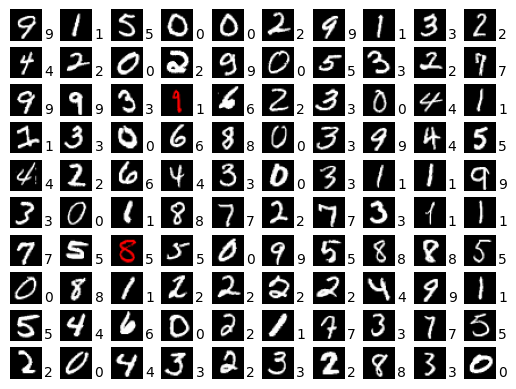

epoch: 9, index: 0, loss: 0.0008
epoch: 9, index: 100, loss: 0.0018
epoch: 9, index: 200, loss: 0.0012
epoch: 9, index: 300, loss: 0.0019
epoch: 9, index: 400, loss: 0.0015
epoch: 9, index: 500, loss: 0.0005
epoch: 9, index: 600, loss: 0.0010
epoch: 9, index: 700, loss: 0.0002
epoch: 9, index: 800, loss: 0.0009
epoch: 9, index: 900, loss: 0.0010

Test set: Average loss: 0.0852, Accuracy: 9821/10000 (98.21%)



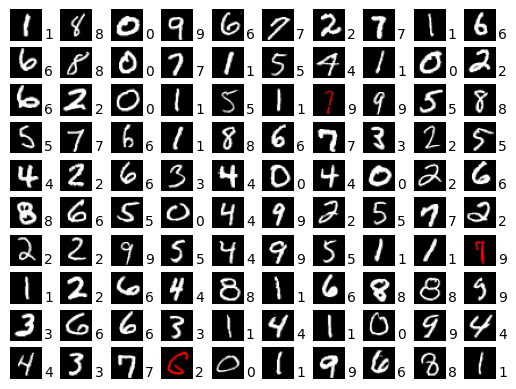

epoch: 10, index: 0, loss: 0.0016
epoch: 10, index: 100, loss: 0.0000
epoch: 10, index: 200, loss: 0.0035
epoch: 10, index: 300, loss: 0.0010
epoch: 10, index: 400, loss: 0.0041
epoch: 10, index: 500, loss: 0.0016
epoch: 10, index: 600, loss: 0.0002
epoch: 10, index: 700, loss: 0.0007
epoch: 10, index: 800, loss: 0.0166
epoch: 10, index: 900, loss: 0.0030

Test set: Average loss: 0.0871, Accuracy: 9824/10000 (98.24%)



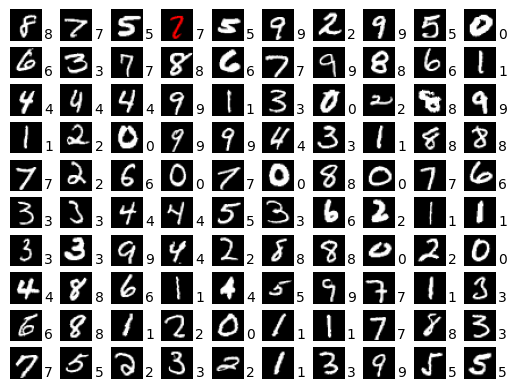

epoch: 1, index: 0, loss: 2.3390
epoch: 1, index: 100, loss: 0.2268
epoch: 1, index: 200, loss: 0.2446
epoch: 1, index: 300, loss: 0.1872
epoch: 1, index: 400, loss: 0.0874
epoch: 1, index: 500, loss: 0.0397
epoch: 1, index: 600, loss: 0.2530
epoch: 1, index: 700, loss: 0.1769
epoch: 1, index: 800, loss: 0.0573
epoch: 1, index: 900, loss: 0.0183

Test set: Average loss: 0.1495, Accuracy: 9536/10000 (95.36%)



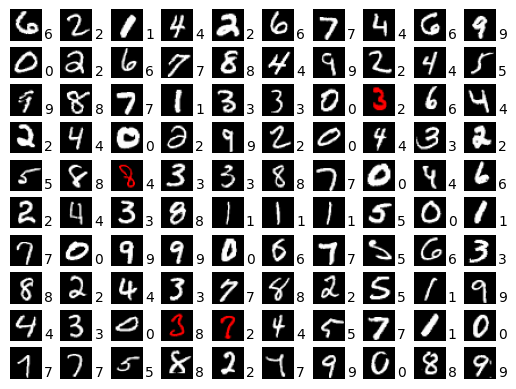

epoch: 2, index: 0, loss: 0.0432
epoch: 2, index: 100, loss: 0.1177
epoch: 2, index: 200, loss: 0.0920
epoch: 2, index: 300, loss: 0.1147
epoch: 2, index: 400, loss: 0.0644
epoch: 2, index: 500, loss: 0.1025
epoch: 2, index: 600, loss: 0.0118
epoch: 2, index: 700, loss: 0.0660
epoch: 2, index: 800, loss: 0.1647
epoch: 2, index: 900, loss: 0.2009

Test set: Average loss: 0.0764, Accuracy: 9773/10000 (97.73%)



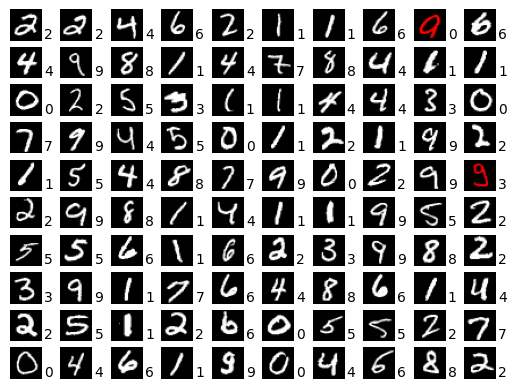

epoch: 3, index: 0, loss: 0.0333
epoch: 3, index: 100, loss: 0.0570
epoch: 3, index: 200, loss: 0.0515
epoch: 3, index: 300, loss: 0.1374
epoch: 3, index: 400, loss: 0.0959
epoch: 3, index: 500, loss: 0.0203
epoch: 3, index: 600, loss: 0.0808
epoch: 3, index: 700, loss: 0.0532
epoch: 3, index: 800, loss: 0.0857
epoch: 3, index: 900, loss: 0.0427

Test set: Average loss: 0.0674, Accuracy: 9807/10000 (98.07%)



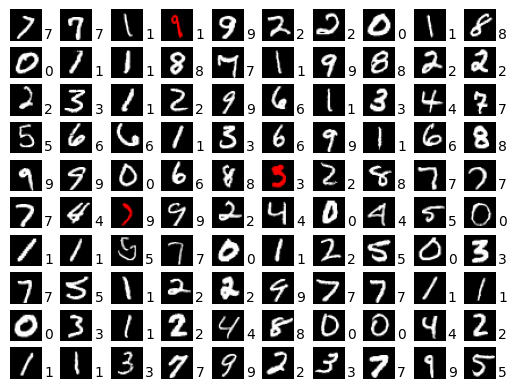

epoch: 4, index: 0, loss: 0.0794
epoch: 4, index: 100, loss: 0.0878
epoch: 4, index: 200, loss: 0.0052
epoch: 4, index: 300, loss: 0.0272
epoch: 4, index: 400, loss: 0.0366
epoch: 4, index: 500, loss: 0.0188
epoch: 4, index: 600, loss: 0.0010
epoch: 4, index: 700, loss: 0.0071
epoch: 4, index: 800, loss: 0.0057
epoch: 4, index: 900, loss: 0.1613

Test set: Average loss: 0.0596, Accuracy: 9819/10000 (98.19%)



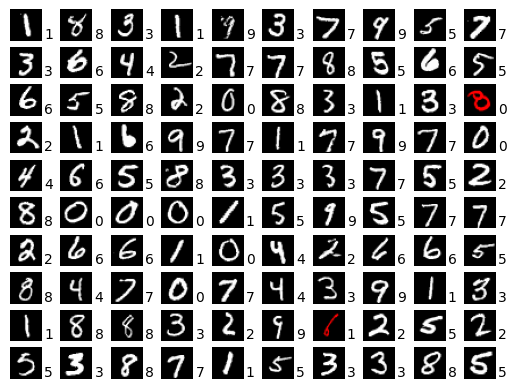

epoch: 5, index: 0, loss: 0.0720
epoch: 5, index: 100, loss: 0.0600
epoch: 5, index: 200, loss: 0.0239
epoch: 5, index: 300, loss: 0.0127
epoch: 5, index: 400, loss: 0.0068
epoch: 5, index: 500, loss: 0.0017
epoch: 5, index: 600, loss: 0.0038
epoch: 5, index: 700, loss: 0.0018
epoch: 5, index: 800, loss: 0.0155
epoch: 5, index: 900, loss: 0.0671

Test set: Average loss: 0.0588, Accuracy: 9830/10000 (98.30%)



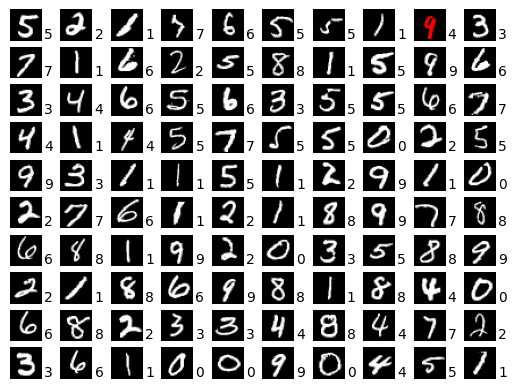

epoch: 6, index: 0, loss: 0.1146
epoch: 6, index: 100, loss: 0.0131
epoch: 6, index: 200, loss: 0.0037
epoch: 6, index: 300, loss: 0.0009
epoch: 6, index: 400, loss: 0.0012
epoch: 6, index: 500, loss: 0.0027
epoch: 6, index: 600, loss: 0.0649
epoch: 6, index: 700, loss: 0.0004
epoch: 6, index: 800, loss: 0.0615
epoch: 6, index: 900, loss: 0.0187

Test set: Average loss: 0.0598, Accuracy: 9831/10000 (98.31%)



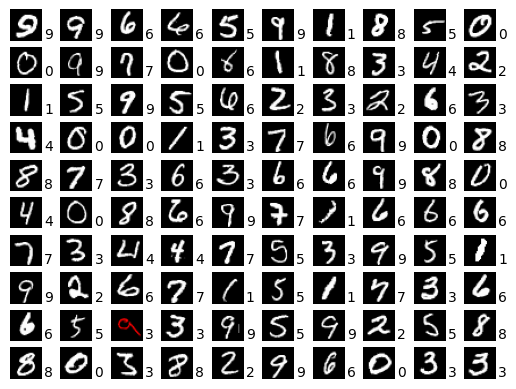

epoch: 7, index: 0, loss: 0.0090
epoch: 7, index: 100, loss: 0.0076
epoch: 7, index: 200, loss: 0.0559
epoch: 7, index: 300, loss: 0.0136
epoch: 7, index: 400, loss: 0.0023
epoch: 7, index: 500, loss: 0.0026
epoch: 7, index: 600, loss: 0.0044
epoch: 7, index: 700, loss: 0.0015
epoch: 7, index: 800, loss: 0.0015
epoch: 7, index: 900, loss: 0.0392

Test set: Average loss: 0.0584, Accuracy: 9834/10000 (98.34%)



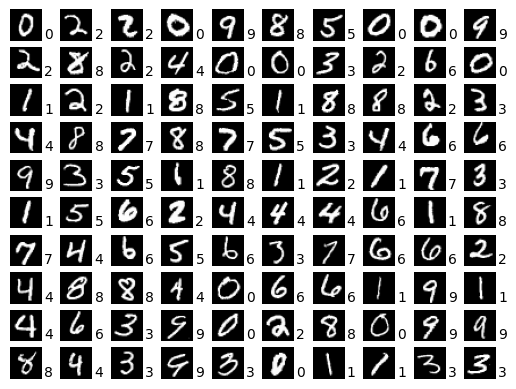

epoch: 8, index: 0, loss: 0.0027
epoch: 8, index: 100, loss: 0.0005
epoch: 8, index: 200, loss: 0.0044
epoch: 8, index: 300, loss: 0.0339
epoch: 8, index: 400, loss: 0.0010
epoch: 8, index: 500, loss: 0.0011
epoch: 8, index: 600, loss: 0.0476
epoch: 8, index: 700, loss: 0.0080
epoch: 8, index: 800, loss: 0.0005
epoch: 8, index: 900, loss: 0.0027

Test set: Average loss: 0.0592, Accuracy: 9840/10000 (98.40%)



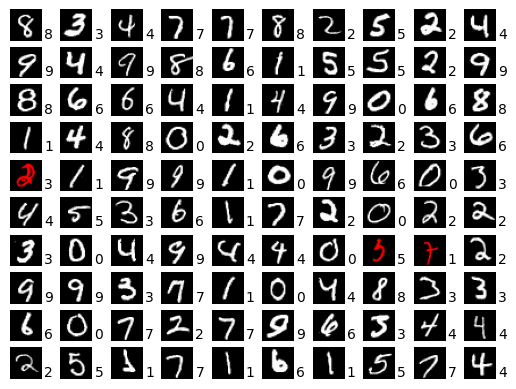

epoch: 9, index: 0, loss: 0.0021
epoch: 9, index: 100, loss: 0.0053
epoch: 9, index: 200, loss: 0.0036
epoch: 9, index: 300, loss: 0.0151
epoch: 9, index: 400, loss: 0.0006
epoch: 9, index: 500, loss: 0.0377
epoch: 9, index: 600, loss: 0.0018
epoch: 9, index: 700, loss: 0.0384
epoch: 9, index: 800, loss: 0.0203
epoch: 9, index: 900, loss: 0.0067

Test set: Average loss: 0.0616, Accuracy: 9843/10000 (98.43%)



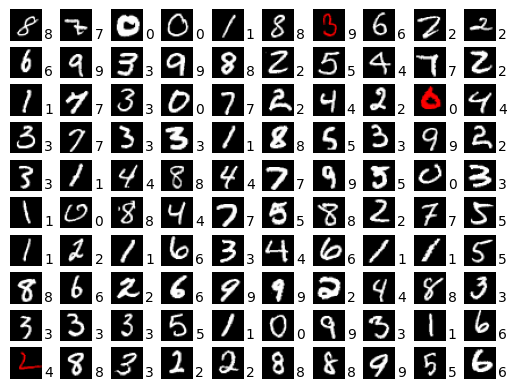

epoch: 10, index: 0, loss: 0.0112
epoch: 10, index: 100, loss: 0.0020
epoch: 10, index: 200, loss: 0.0262
epoch: 10, index: 300, loss: 0.0007
epoch: 10, index: 400, loss: 0.0260
epoch: 10, index: 500, loss: 0.0170
epoch: 10, index: 600, loss: 0.0225
epoch: 10, index: 700, loss: 0.0091
epoch: 10, index: 800, loss: 0.0015
epoch: 10, index: 900, loss: 0.0006

Test set: Average loss: 0.0611, Accuracy: 9851/10000 (98.51%)



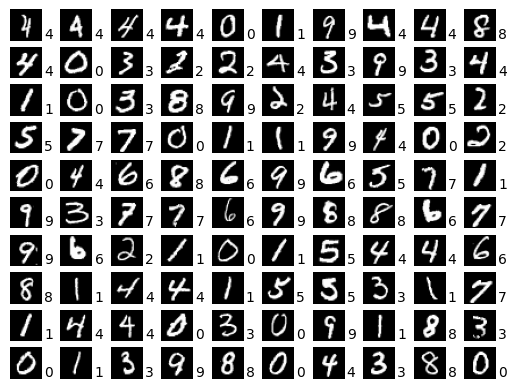

epoch: 1, index: 0, loss: 2.3213
epoch: 1, index: 100, loss: 0.3437
epoch: 1, index: 200, loss: 0.2511
epoch: 1, index: 300, loss: 0.0695
epoch: 1, index: 400, loss: 0.0891
epoch: 1, index: 500, loss: 0.1847
epoch: 1, index: 600, loss: 0.1731
epoch: 1, index: 700, loss: 0.0895
epoch: 1, index: 800, loss: 0.1827
epoch: 1, index: 900, loss: 0.1433

Test set: Average loss: 0.0943, Accuracy: 9723/10000 (97.23%)



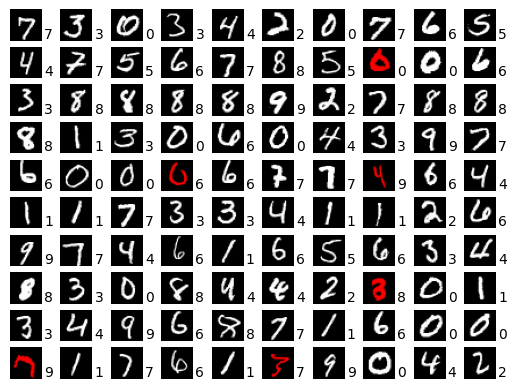

epoch: 2, index: 0, loss: 0.0799
epoch: 2, index: 100, loss: 0.0503
epoch: 2, index: 200, loss: 0.0440
epoch: 2, index: 300, loss: 0.0084
epoch: 2, index: 400, loss: 0.0572
epoch: 2, index: 500, loss: 0.1266
epoch: 2, index: 600, loss: 0.0389
epoch: 2, index: 700, loss: 0.0159
epoch: 2, index: 800, loss: 0.0539
epoch: 2, index: 900, loss: 0.0401

Test set: Average loss: 0.0773, Accuracy: 9766/10000 (97.66%)



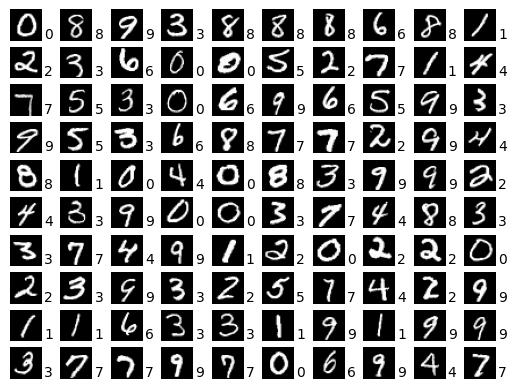

epoch: 3, index: 0, loss: 0.0490
epoch: 3, index: 100, loss: 0.0493
epoch: 3, index: 200, loss: 0.0211
epoch: 3, index: 300, loss: 0.0429
epoch: 3, index: 400, loss: 0.0374
epoch: 3, index: 500, loss: 0.0113
epoch: 3, index: 600, loss: 0.0158
epoch: 3, index: 700, loss: 0.0154
epoch: 3, index: 800, loss: 0.0047
epoch: 3, index: 900, loss: 0.0632

Test set: Average loss: 0.0786, Accuracy: 9797/10000 (97.97%)



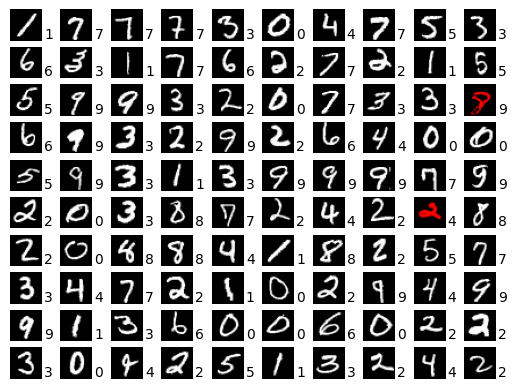

epoch: 4, index: 0, loss: 0.0029
epoch: 4, index: 100, loss: 0.0103
epoch: 4, index: 200, loss: 0.0005
epoch: 4, index: 300, loss: 0.0250
epoch: 4, index: 400, loss: 0.0012
epoch: 4, index: 500, loss: 0.0029
epoch: 4, index: 600, loss: 0.0012
epoch: 4, index: 700, loss: 0.0018
epoch: 4, index: 800, loss: 0.0032
epoch: 4, index: 900, loss: 0.0105

Test set: Average loss: 0.0825, Accuracy: 9797/10000 (97.97%)



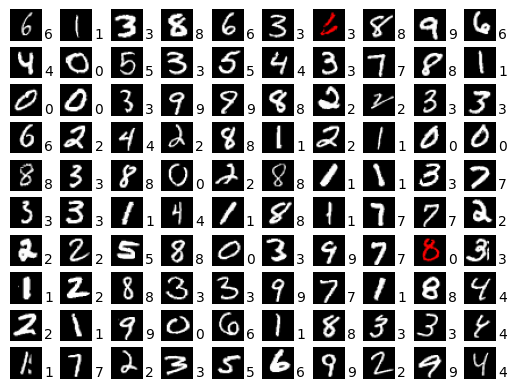

epoch: 5, index: 0, loss: 0.0016
epoch: 5, index: 100, loss: 0.0009
epoch: 5, index: 200, loss: 0.0186
epoch: 5, index: 300, loss: 0.0007
epoch: 5, index: 400, loss: 0.0021
epoch: 5, index: 500, loss: 0.0004
epoch: 5, index: 600, loss: 0.0130
epoch: 5, index: 700, loss: 0.0007
epoch: 5, index: 800, loss: 0.0002
epoch: 5, index: 900, loss: 0.0002

Test set: Average loss: 0.0889, Accuracy: 9813/10000 (98.13%)



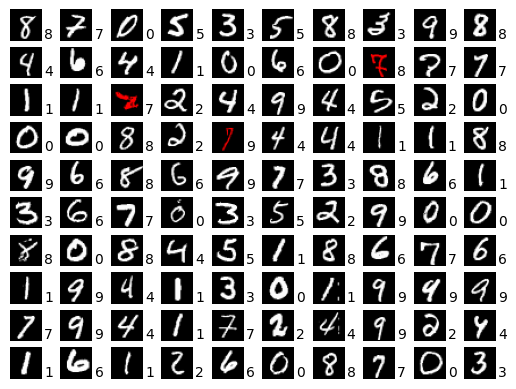

epoch: 6, index: 0, loss: 0.0014
epoch: 6, index: 100, loss: 0.0003
epoch: 6, index: 200, loss: 0.0004
epoch: 6, index: 300, loss: 0.0003
epoch: 6, index: 400, loss: 0.0005
epoch: 6, index: 500, loss: 0.0000
epoch: 6, index: 600, loss: 0.0002
epoch: 6, index: 700, loss: 0.0013
epoch: 6, index: 800, loss: 0.0002
epoch: 6, index: 900, loss: 0.0047

Test set: Average loss: 0.0936, Accuracy: 9821/10000 (98.21%)



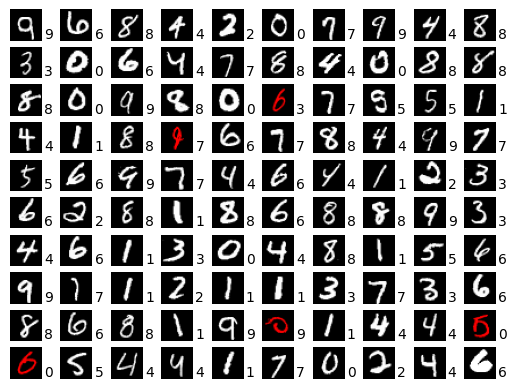

epoch: 7, index: 0, loss: 0.1630
epoch: 7, index: 100, loss: 0.0007
epoch: 7, index: 200, loss: 0.0002
epoch: 7, index: 300, loss: 0.0001
epoch: 7, index: 400, loss: 0.0001
epoch: 7, index: 500, loss: 0.0002
epoch: 7, index: 600, loss: 0.0006
epoch: 7, index: 700, loss: 0.0162
epoch: 7, index: 800, loss: 0.0003
epoch: 7, index: 900, loss: 0.0001

Test set: Average loss: 0.0994, Accuracy: 9817/10000 (98.17%)



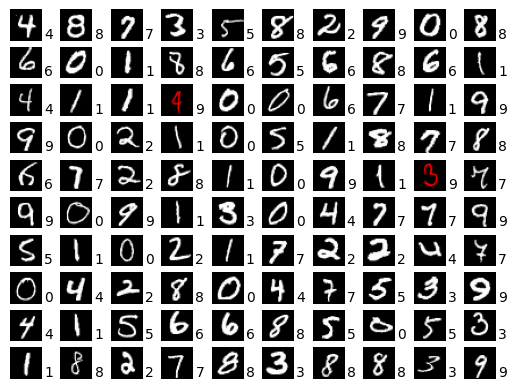

epoch: 8, index: 0, loss: 0.0002
epoch: 8, index: 100, loss: 0.0001
epoch: 8, index: 200, loss: 0.0007
epoch: 8, index: 300, loss: 0.0006
epoch: 8, index: 400, loss: 0.0003
epoch: 8, index: 500, loss: 0.0004
epoch: 8, index: 600, loss: 0.0012
epoch: 8, index: 700, loss: 0.0003
epoch: 8, index: 800, loss: 0.0001
epoch: 8, index: 900, loss: 0.0005

Test set: Average loss: 0.1010, Accuracy: 9823/10000 (98.23%)



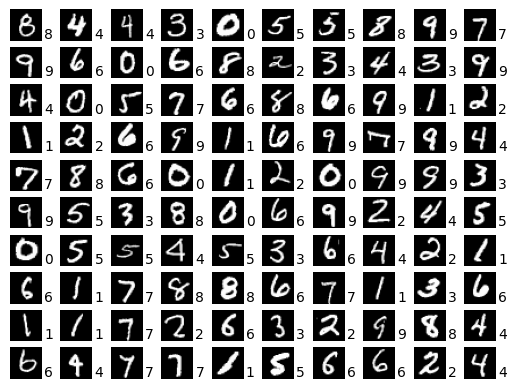

epoch: 9, index: 0, loss: 0.0004
epoch: 9, index: 100, loss: 0.0213
epoch: 9, index: 200, loss: 0.0001
epoch: 9, index: 300, loss: 0.0003
epoch: 9, index: 400, loss: 0.0002
epoch: 9, index: 500, loss: 0.0000
epoch: 9, index: 600, loss: 0.0003
epoch: 9, index: 700, loss: 0.0001
epoch: 9, index: 800, loss: 0.0001
epoch: 9, index: 900, loss: 0.0008

Test set: Average loss: 0.1038, Accuracy: 9818/10000 (98.18%)



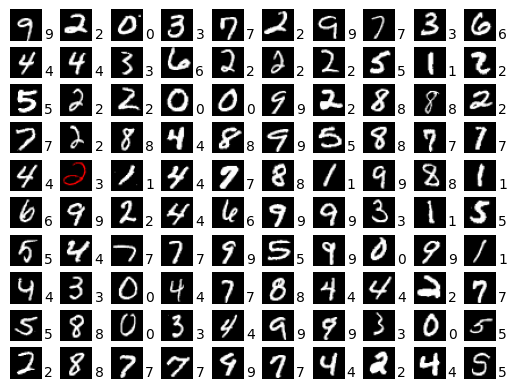

epoch: 10, index: 0, loss: 0.0000
epoch: 10, index: 100, loss: 0.0000
epoch: 10, index: 200, loss: 0.0001
epoch: 10, index: 300, loss: 0.0001
epoch: 10, index: 400, loss: 0.0000
epoch: 10, index: 500, loss: 0.0000
epoch: 10, index: 600, loss: 0.0001
epoch: 10, index: 700, loss: 0.0000
epoch: 10, index: 800, loss: 0.0001
epoch: 10, index: 900, loss: 0.0001

Test set: Average loss: 0.1047, Accuracy: 9821/10000 (98.21%)



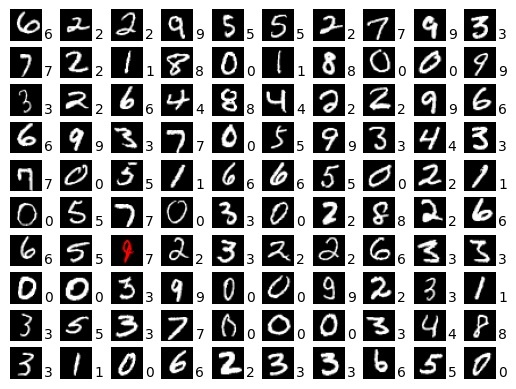

epoch: 1, index: 0, loss: 2.2711
epoch: 1, index: 100, loss: 0.3227
epoch: 1, index: 200, loss: 0.2295
epoch: 1, index: 300, loss: 0.1615


In [ ]:
for model_class in [FCNet1, FCNet2, FCNet3, ConvNet1, ConvNet2, ConvNet3]:
    # hyper parameters
    batch_size = 64
    test_batch_size = 1000
    epochs = 10
    lr = 1.0
    gamma = 0.7
    log_interval = 100

    # use GPU if available
    use_cuda = torch.cuda.is_available()
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # initialize data loaders
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])), batch_size=batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    model = model_class()
    if use_cuda:
        model = model.cuda()

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        # train one epoch
        train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

        # run on test dataset
        validate(model, use_cuda, test_loader)
        scheduler.step()


        torch.save(model.state_dict(), "models/mnist/checkpoint.pt")